In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.constants import M_sun, G
import astropy.units as u
import os
top = os.getenv('HOME')+'/codes/dispatch2/'
os.chdir(top+'experiments/ISM/python')
import tqdm


import sys
sys.path.insert(0,top+'utilities/python')
import dispatch as dis
import dispatch.select as dse
import dispatch.graphics as dgr
import dispatch.particles as dpa

sys.path.append('my_funcs/')
from plot_funcs import plot_density, plot_velocity
from calc_funcs import calc_mean_angvec, dist, calc_meanL, patch_diag, calc_ang

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [3]:
class pipeline():
    def __init__(self, snap = 710 , run = 'my_core_13restart'):
        self.sn = dis.snapshot(snap, run)
        self.star_pos = self.sn.sinks[13][0].position
        self.star_vel = self.sn.sinks[13][0].velocity
        self.cgs_mass = self.sn.scaling.m / self.sn.cgs.m_sun
        self.cgs_time = self.sn.scaling.t / self.sn.cgs.yr    # [yr]
        self.cgs_length = self.sn.scaling.l / self.sn.cgs.au  # [au]
        self.cgs_density = self.sn.scaling.d / 0.001          # [g/cm^3]
        self.kms_velocity = (self.sn.scaling.l / self.sn.scaling.t) / 1e5 
        self.M_star = self.sn.sinks[13][0].mass * self.cgs_mass * M_sun
        self.time = self.sn.time * self.cgs_time # [yr]
        self.cyl_calculated = False

        for p in self.sn.patches: # Should take 3s to loop over the patches like this
            XX, YY, ZZ = np.meshgrid(p.xi - self.star_pos[0], p.yi - self.star_pos[1], p.zi - self.star_pos[2], indexing='ij')
            p.rel_xyz = np.array([XX, YY, ZZ]); 
            p.dist_xyz = np.linalg.norm(p.rel_xyz, axis = 0) 
            p.vel_xyz = np.asarray([p.var('ux'), p.var('uy'), p.var('uz')]) 
            p.m = p.var('d') * np.prod(p.ds) 
    
    #Calculate mean angular momentum vector
    def calc_L(self, distance = 100,  angle_to_calc = np.array([1, 0, 0]), verbose = 0):
        L = np.zeros(3)
        d = distance / self.cgs_length
        if verbose != 0: 
            patches_skipped = 0 
            contained = 0

        pp = [p for p in self.sn.patches if (p.dist_xyz < d).any()]
        if verbose != 0: print(f'Looping through {len(pp)} patches')

        for p in pp:
            idx = np.nonzero(p.dist_xyz < d)

            if (p.dist_xyz < d).all() and verbose != 0:
             contained += 1
        
            if (p.dist_xyz > d).all():
                if verbose != 0: patches_skipped += 1
                continue

            L_patch = np.cross(p.rel_xyz, p.vel_xyz * p.m , axisa=0, axisb=0, axisc=0)
            L += np.array([np.sum(L_patch[axis][idx]) for axis in range(3)])
        if verbose != 0:
            print("Completely contained patchess:", contained)
            print('Patches skipped:', patches_skipped)
        if isinstance(angle_to_calc, np.ndarray):
            print(f'Angle between the given vector and the mean angular momentum vector: {calc_ang(angle_to_calc, L):2.1f} deg')
  
        self.L =  L / np.linalg.norm(L)


    # Coordinate transformation into cylindrical coordinates
    def calc_cyl(self):
        try:
            self.L
        except:
            self.calc_L()
       
        for p in self.sn.patches:
            p.cyl_z = np.sum(self.L[:, None, None, None] * p.rel_xyz, axis = 0)     # z-coordinate in new axis (Cylindrical)
            p.cyl_r = p.rel_xyz -  p.cyl_z * self.L[:, None, None, None]            # r-coordinate in plane r' = r - ez * r
            p.cyl_R = np.linalg.norm(p.cyl_r, axis = 0) 
            p.e_r = p.cyl_r / p.cyl_R
            p.e_φ = np.cross(self.L, p.e_r, axisa=0, axisb=0, axisc=0)
            p.position_cylZ = np.dot(self.L, p.position - self.star_pos)
            p.position_cylr = (p.position - self.star_pos) - p.position_cylZ * self.L
        self.cyl_calculated = True
    

    #Recalculate mean angular momentum vector after transforming into cylindrical coordiantes
    def recalc_L(self, height = 10, radius = 100, err_deg = 1, verbose = 1):
        if not self.cyl_calculated: self.calc_cyl()
        height /= self.cgs_length; radius /= self.cgs_length

        def recalc():
            L_new = np.zeros(3)
            for p in self.sn.patches:
                idx = np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height)))
                L_patch = np.cross(p.rel_xyz, p.vel_xyz * p.m , axisa=0, axisb=0, axisc=0)
                L_new += np.array([np.sum(L_patch[axis][idx]) for axis in range(3)])
            return L_new / np.linalg.norm(L_new)
        L_new =  recalc()
        L_i = 0
        while calc_ang(self.L, L_new) > err_deg:
            self.L = L_new
            self.calc_cyl()
            L_new = recalc()
            L_i += 1
        if verbose != 0: print(f'Converged mean angular momentum vector after {L_i} iterations')


    # Caculate the disk size and thereby also the azimuthal velocity
    def calc_disksize(self, height = 10, radius = 1000, r_in = 10, radial_bins = 100, a = 0.8, plot = True):
        if not self.cyl_calculated: self.calc_cyl()

        rad_bins = np.logspace(np.log10(r_in), np.log10(radius), radial_bins) / self.cgs_length    
        height /= self.cgs_length; radius /= self.cgs_length

        h_mass_tot = np.zeros(len(rad_bins) - 1)
        h_vφ_tot = np.zeros(len(rad_bins) - 1)
        h_vφ_tot2 = np.zeros(len(rad_bins) - 1)
        for p in self.sn.patches:
            #Cutting which pathces to look through cells (in height) encompass very large and thereby low level patches not representing the orbital velocity in the disk.
            #The strict cut in pacthes has to made in height - several combination have tested
            if abs(p.position_cylZ) <= height and (p.cyl_R < radius).any():
                p.vrel = p.vel_xyz - self.star_vel[:, None, None, None]
                p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
                
                h_mass, _ = np.histogram(p.cyl_R, bins = rad_bins, weights =  p.m)
                h_vφ, _ = np.histogram(p.cyl_R, bins = rad_bins, weights =  p.vφ * p.m)
                h_vφ2, _ = np.histogram(p.cyl_R, bins = rad_bins, weights =  p.vφ**2 * p.m)
                
                h_vφ_tot += h_vφ
                h_mass_tot += h_mass
                h_vφ_tot2 += h_vφ2
        self.vφ = (h_vφ_tot/h_mass_tot) * self.kms_velocity;
        self.vφ2 = (h_vφ_tot2/h_mass_tot) * self.kms_velocity**2;

        r_plot = rad_bins[:-1] + 0.5 * np.diff(rad_bins)
        
        kep_vel = (((G * self.M_star) / (r_plot * self.cgs_length * u.au))**0.5).to('km/s').value

        for i in range(len(self.vφ)):
            if self.vφ[i] / kep_vel[i] < a:
                self.disk_size = r_plot[i] * self.cgs_length
                print(f'Disk size: {self.disk_size:2.1f} au')
                break

        if plot:
            fig, axs = plt.subplots(1, 2, figsize = (20,6),gridspec_kw={'width_ratios': [2, 1.5]})

            σ_φ = np.sqrt(self.vφ2 - self.vφ**2)

            axs[0].loglog(r_plot * self.cgs_length, kep_vel, label = 'Keplerian Orbital Velocity', color = 'black')
            axs[0].loglog(r_plot * self.cgs_length, self.vφ , label = 'Azimuthal velocity v$_φ$', c = 'blue')
            axs[0].fill_between(r_plot * self.cgs_length, self.vφ - σ_φ, self.vφ + σ_φ, alpha = 0.5, label = '$\pm1\sigma_{φ}$')

            axs[0].set(xlabel = 'Distance from sink [AU]', ylabel = 'Orbital speed [km/s]')

            axs[0].legend(frameon = False)
            axs[1].semilogx(r_plot * self.cgs_length, self.vφ / kep_vel, label = 'v$_φ$/v$_K$ ratio', color = 'black', lw = 0.8)
            axs[1].axhline(a, color = 'red', ls = '--', label = f'a = {a}')
            axs[1].axhline(1, color = 'black', ls = '-', alpha = 0.7)
            axs[1].set(xlabel = 'Distance from sink [AU]', ylim = (0.5, 1.1))
            axs[1].legend(frameon = False)


In [4]:
data = pipeline(snap = 362, run = 'my_core_13lacc3') #Initially 4s
print(data.time)

18255.99550403226


In [5]:
test_vector = np.array([0.5 ,-0.5, 0.5]); test_vector /=np.linalg.norm(test_vector)

Looping through 962 patches
Completely contained patchess: 662
Patches skipped: 0
Angle between the given vector and the mean angular momentum vector: 8.4 deg
[ 0.59584971 -0.45760812  0.65996813]
Converged mean angular momentum vector after 1 iterations
[ 0.63326079 -0.37308645  0.67807616]
Disk size: 10.7 au


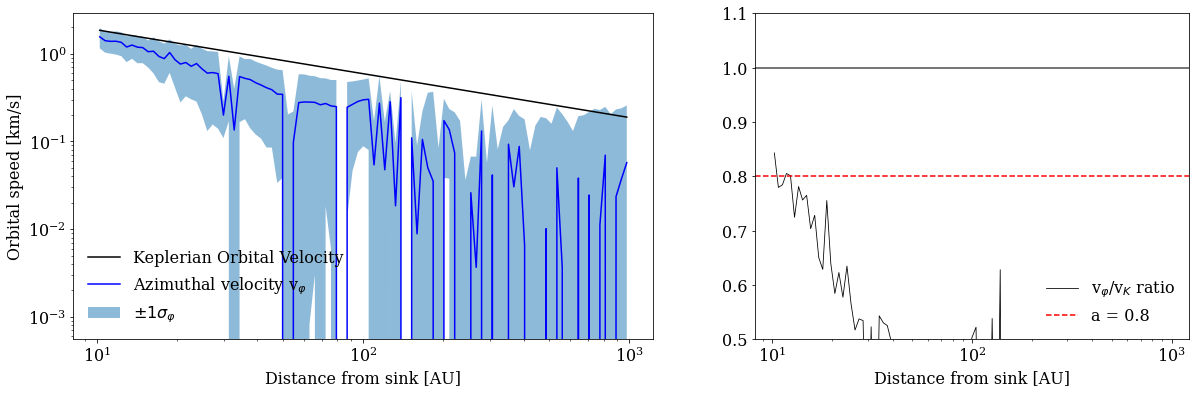

In [11]:
data.calc_L( verbose=1, angle_to_calc = test_vector)
print(data.L)
data.recalc_L()
print(data.L)
data.calc_disksize()

In [7]:
data.recalc_L()

Converged mean angular momentum vector after 1 iterations


In [8]:
data = pipeline(snap = 437, run = 'my_core_13lacc2') #23s last time - this took 5s
print(data.time)
test_vector = np.array([0.5 ,-0.5, 0.5]); test_vector /=np.linalg.norm(test_vector)
data.calc_L( verbose=1)
data.calc_cyl()
data.L

KeyboardInterrupt: 

In [ ]:
data = pipeline(snap = 473, run = 'my_core_13lacc2') #23s last time - this took 5s
print(data.time)
test_vector = np.array([0.5 ,-0.5, 0.5]); test_vector /=np.linalg.norm(test_vector)
data.calc_L( verbose=1)
data.calc_cyl()
data.recalc_L()
data.L

32730.39193937197
Looping through 961 patches
Completely contained patchess: 662
Patches skipped: 0
Angle between the given vector and the mean angular momentum vector: 54.5 deg
Converged mean angular momentum vector after 0 iterations


array([ 0.5808841 ,  0.59610112, -0.55428975])

/tmp/ipykernel_1319501/1919950668.py:119: RuntimeWarning: invalid value encountered in true_divide
  self.vφ = (h_vφ_tot/h_mass_tot) * self.kms_velocity;
/tmp/ipykernel_1319501/1919950668.py:120: RuntimeWarning: invalid value encountered in true_divide
  self.vφ2 = (h_vφ_tot2/h_mass_tot) * self.kms_velocity**2;


Disk size: 21.6 au


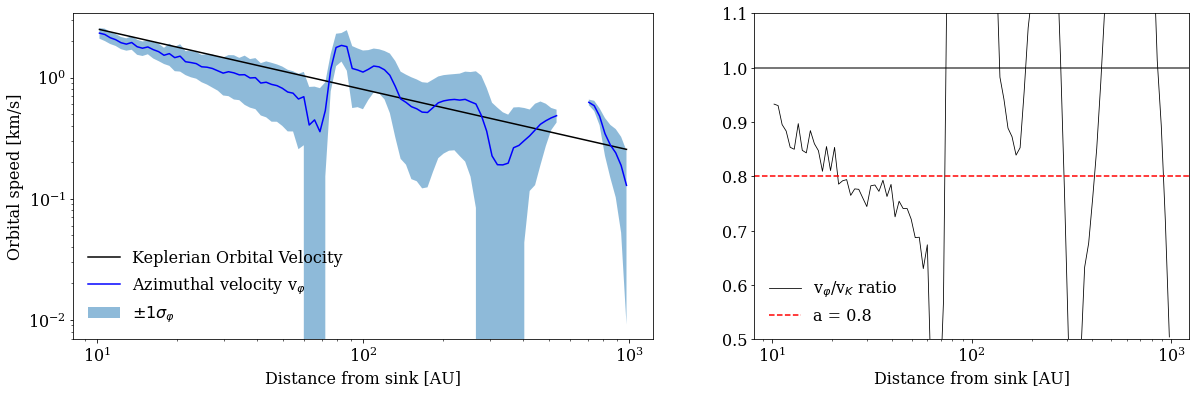

In [ ]:
for p in data.sn.patches:
    if p.id == 1853:
        break

In [ ]:
np.linalg.norm(p.position_cylr)

4.064279703251377e-08